In [158]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [159]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device_id = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(device_id)
print(device, device_id, device_name)

a = torch.FloatTensor([1.0,2.0])
b = torch.FloatTensor([1.0,2.0]).to(device)
print(a.device, b.device)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100,50)
        self.fc2 = nn.Linear(50,10)
        self.out = nn.Linear(10,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

model = Model()
print(next(model.parameters()).is_cuda)
gpu_model = model.to(device)
print(next(gpu_model.parameters()).is_cuda)

print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

True
cuda 0 NVIDIA GeForce RTX 3070
cpu cuda:0
False
True
307878400
1096810496


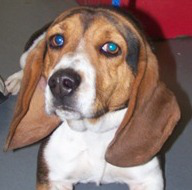

In [160]:
with Image.open('../Data/CATS_DOGS/CATS_DOGS/test/DOG/9496.jpg') as im:
    display(im)

In [161]:
path = '../Data/CATS_DOGS/CATS_DOGS/'
img_names = []

for folder, sub_folders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

In [162]:
len(img_names)

24994

In [163]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

print(len(img_sizes))
print(len(rejected))

24994
0


In [164]:
df = pd.DataFrame(img_sizes)
df.describe()

,0,1
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


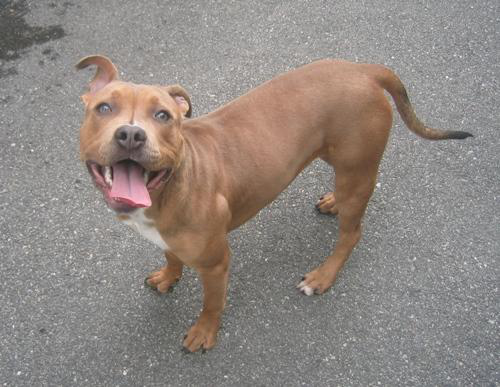

In [165]:
img = Image.open('../Data/CATS_DOGS/CATS_DOGS/train/DOG/14.jpg')
display(img)

In [166]:
img.size

(500, 387)

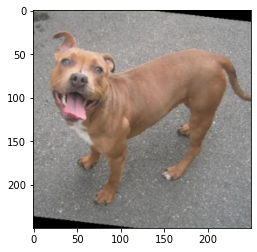

In [167]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.Resize(250),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])

im = transform(img)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [168]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [169]:
root = '../Data/CATS_DOGS/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform=test_transforms)

In [170]:
batch_size = 100
learning_rate = 0.001
input_size = 100
output_size = 2
epochs = 5

train_data_size = len(train_data)
test_data_size = len(test_data)
print('Train data size:', train_data_size, '& Test data size:', test_data_size)

Train data size: 18743 & Test data size: 6251


In [171]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

train_loader_size = len(train_loader)
test_loader_size = len(test_loader)
class_names = train_data.classes

print(class_names)

['CAT', 'DOG']


In [172]:
images = None
for images, labels in train_loader:
    images = images
    break

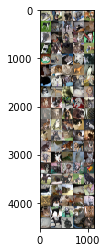

In [173]:
im = make_grid(images, nrow=5)

im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [174]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(54*54*16,120)
        self.fc2 =nn.Linear(120,84)
        self.fc3 =nn.Linear(84,2)
# (((224-2)/2)-2)/2 = 54.5 = 54
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,54*54*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [175]:
model = CNN().to(device)
if os.path.exists('./Real_image_data_cnn_state.pt'):
    model.load_state_dict(torch.load('./Real_image_data_cnn_state.pt'))
print([p.numel() for p in model.parameters() if p.requires_grad])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

[162, 6, 864, 16, 5598720, 120, 10080, 84, 168, 2]


In [176]:
def test_accuracy_check(NN_model):
    test_correct = 0
    with torch.no_grad():
        for batch_index, (x_test, y_test) in enumerate(test_loader):
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            y_pred = NN_model(x_test)

            predicted = torch.max(y_pred, dim=1)[1]
            batch_correct = (predicted == y_test).sum()

            test_correct += batch_correct
    accuracy = (test_correct/test_data_size) * 100
    print(f"Test Data Accuracy: {test_correct} / {test_data_size} = {accuracy:.3f}%")

    return accuracy

In [137]:
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    train_correct = 0
    test_correct = 0
    for batch_index, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, dim=1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        if batch_index == 0:
            print(f'Training Epoch: {epoch} Loss: {loss.item():.3f}')
            train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy_val = (train_correct / train_data_size)*100
    train_accuracy.append(train_accuracy_val.item())
    print(f'Training Data Accuracy: {train_correct} / {train_data_size} = {train_accuracy_val:.3f}%')

    test_accuracy_val = test_accuracy_check(model)

    test_accuracy.append(test_accuracy_val.item())

torch.save(model.state_dict(),'./Real_image_data_cnn_state.pt')

Training Epoch: 0 Loss: 94.095
Training Data Accuracy: 10886 / 18743 = 58.080%
Test Data Accuracy: 4254 / 6251 = 68.053%
Training Epoch: 1 Loss: 0.573
Training Data Accuracy: 13680 / 18743 = 72.987%
Test Data Accuracy: 4732 / 6251 = 75.700%
Training Epoch: 2 Loss: 0.495
Training Data Accuracy: 14459 / 18743 = 77.143%
Test Data Accuracy: 4771 / 6251 = 76.324%
Training Epoch: 3 Loss: 0.381
Training Data Accuracy: 14750 / 18743 = 78.696%
Test Data Accuracy: 4862 / 6251 = 77.780%
Training Epoch: 4 Loss: 0.487
Training Data Accuracy: 15108 / 18743 = 80.606%
Test Data Accuracy: 4906 / 6251 = 78.483%


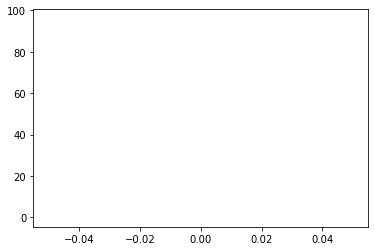

In [177]:
plt.plot(train_losses)
plt.plot(train_accuracy)
plt.plot(test_accuracy)

In [178]:
AlexNetModel = models.alexnet(pretrained=True)

In [179]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [180]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [181]:
AlexNetModel.classifier = nn.Sequential(
    nn.Linear(9216, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim=1)
)

In [182]:
AlexNetModel = AlexNetModel.to(device)

In [183]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [184]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

In [185]:
train_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    train_correct = 0
    test_correct = 0
    for batch_index, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = AlexNetModel(x_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, dim=1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        if batch_index == 0:
            print(f'Training Epoch: {epoch} Loss: {loss.item():.3f}')
            train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy_val = (train_correct / train_data_size)*100
    train_accuracy.append(train_accuracy_val.item())
    print(f'Training Data Accuracy: {train_correct} / {train_data_size} = {train_accuracy_val:.3f}%')

    test_accuracy_val = test_accuracy_check(AlexNetModel)

    test_accuracy.append(test_accuracy_val.item())

torch.save(model.state_dict(),'./Real_image_data_cnn_state.pt')

Training Epoch: 0 Loss: 0.805
Training Data Accuracy: 17581 / 18743 = 93.800%
Test Data Accuracy: 5972 / 6251 = 95.537%
Training Epoch: 1 Loss: 0.022
Training Data Accuracy: 17936 / 18743 = 95.694%
Test Data Accuracy: 5953 / 6251 = 95.233%
Training Epoch: 2 Loss: 0.094
Training Data Accuracy: 18005 / 18743 = 96.063%
Test Data Accuracy: 5946 / 6251 = 95.121%
Training Epoch: 3 Loss: 0.114
Training Data Accuracy: 18057 / 18743 = 96.340%
Test Data Accuracy: 5986 / 6251 = 95.761%
Training Epoch: 4 Loss: 0.121
Training Data Accuracy: 18103 / 18743 = 96.585%
Test Data Accuracy: 5984 / 6251 = 95.729%


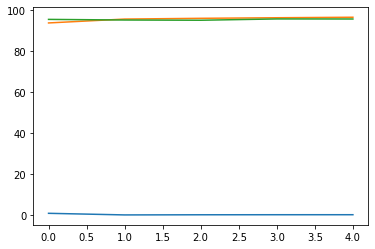

In [186]:
plt.plot(train_losses)
plt.plot(train_accuracy)
plt.plot(test_accuracy)